# Caverns with constraints

In [1]:
import importlib
import os
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from pyfluids import Fluid, FluidsList, Input

from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

CRS = 23029

## Halite data

In [3]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

In [4]:
ds, extent = fns.read_dat_file(dat_path=DATA_DIR)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [6]:
DATA_DIR = os.path.join(
    "data",
    "exploration-wells-irish-offshore",
    "Exploration_Wells_Irish_Offshore.shapezip.zip",
)

wells = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!"
        + [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [7]:
wells = wells[wells["AREA"].str.contains("Kish")].to_crs(CRS)

# 500 m buffer - suggested in draft OREDP II p. 108
wells_b = gpd.GeoDataFrame(geometry=wells.buffer(500))

### Wind farms

In [8]:
DATA_DIR = os.path.join(
    "data", "wind-farms-foreshore-process", "wind-farms-foreshore-process.zip"
)

wind_farms = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!"
        + [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [9]:
# wind farms near Kish Basin
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = (
    wind_farms.to_crs(CRS)
    .sjoin(gpd.GeoDataFrame(geometry=extent.buffer(3000)))
    .reset_index()
    .sort_values("Name")
)

wind_farms.drop(columns=["index_right"], inplace=True)

### Frequent shipping routes

In [11]:
DATA_DIR = os.path.join(
    "data", "shipping", "shipping_frequently_used_routes.zip"
)

shipping = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!"
        + [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [12]:
shipping = (
    shipping.to_crs(CRS)
    .sjoin(gpd.GeoDataFrame(geometry=extent.buffer(3000)))
    .reset_index()
)

shipping.drop(columns=["index_right"], inplace=True)

# routes near Kish Basin
# 1NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping_b = gpd.GeoDataFrame(geometry=shipping.buffer(1852)).dissolve()

### Shipwrecks

In [13]:
DATA_DIR = os.path.join(
    "data", "heritage", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
)

shipwrecks = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!"
        + [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [14]:
shipwrecks = (
    shipwrecks.to_crs(CRS)
    .sjoin(gpd.GeoDataFrame(geometry=extent.buffer(3000)))
    .reset_index()
)

shipwrecks.drop(columns=["index_right"], inplace=True)

# Archaeological Exclusion Zones recommendation
shipwrecks_b = gpd.GeoDataFrame(geometry=shipwrecks.buffer(100))

### Subsea cables

In [15]:
DATA_DIR = os.path.join("data", "kis-orca", "KIS-ORCA.gpkg")

cables = gpd.read_file(DATA_DIR)

cables = cables.to_crs(CRS)

# remove point features
cables = cables.drop(range(3)).reset_index(drop=True)

# 750 m buffer - suggested in draft OREDP II p. 109-111
cables_b = gpd.GeoDataFrame(geometry=cables.buffer(750)).dissolve()

### Distance from salt formation edge

In [16]:
buffer_edge = {}
for halite in ds.halite.values:
    buffer_edge[halite] = fns.halite_shape(dat_xr=ds, halite=halite)
    # 3 times the cavern diameter
    buffer_edge[halite] = gpd.GeoDataFrame(
        geometry=buffer_edge[halite].boundary.buffer(3 * 80)
    ).overlay(buffer_edge[halite], how="intersection")

## Zones of interest

In [17]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [18]:
def generate_caverns_with_constraints(zones_gdf, zones_ds, diameter):
    """
    Add constraints to cavern configuration
    """

    print("Without constraints...")
    cavern_df = fns.generate_caverns_hexagonal_grid(
        dat_extent=extent, zones_df=zones_gdf, diameter=diameter
    )
    cavern_df = fns.cavern_dataframe(dat_zone=zones_ds, cavern_df=cavern_df)

    print("-" * 60)
    print("Exclude exploration wells...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, wells_b, predicate="intersects"), how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude wind farms...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, wind_farms, predicate="intersects"),
        how="difference",
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude shipwrecks...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, shipwrecks_b, predicate="intersects"),
        how="difference",
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude frequent shipping routes...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, shipping_b, predicate="intersects"),
        how="difference",
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude subsea cables...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, cables_b, predicate="intersects"),
        how="difference",
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude salt formation edges...")
    cavern_dict = {}
    for h in cavern_df["halite"].unique():
        cavern_dict[h] = cavern_df[cavern_df["halite"] == h]
        cavern_dict[h] = cavern_dict[h].overlay(
            gpd.sjoin(cavern_dict[h], buffer_edge[h], predicate="intersects"),
            how="difference",
        )
    cavern_df = pd.concat(cavern_dict.values())
    print("Number of potential caverns:", len(cavern_df))

    return cavern_df

In [19]:
caverns = generate_caverns_with_constraints(zones, zds, 80)

Without constraints...
Number of potential caverns: 4336
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 4316
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3944
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 3941
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1549
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1465
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 1390


In [20]:
caverns.describe()[["Thickness", "TopDepth"]]

,Thickness,TopDepth
count,1390.000000,1390.000000
mean,301.271103,1032.944181
std,82.154311,417.252534
min,175.062400,420.019200
25%,235.347600,695.388100
50%,291.285400,966.166300
75%,353.398775,1361.360500
max,754.985800,1917.627900


In [20]:
# label caverns by height
conditions = [
    (caverns["Thickness"] < (155 + 90)),
    (caverns["Thickness"] >= (155 + 90)) & (caverns["Thickness"] < (311 + 90)),
    (caverns["Thickness"] >= (311 + 90)),
]
choices = ["85", "155", "311"]
caverns["height"] = np.select(conditions, choices)

In [21]:
# label caverns by depth
conditions = [
    (caverns["TopDepth"] < (1000 - 80)),
    (caverns["TopDepth"] >= (1000 - 80))
    & (caverns["TopDepth"] <= (1500 - 80)),
    (caverns["TopDepth"] > (1500 - 80)),
]
choices = ["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"]
caverns["depth"] = np.select(conditions, choices)

## Crop data layers

In [22]:
# land boundary
DATA_DIR = os.path.join(
    "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
)

land = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!"
        + [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

land = land.dissolve().to_crs(CRS)

In [23]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [24]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [25]:
# # merge salt edge buffer
# buffer_edge = pd.concat(buffer_edge.values()).dissolve()

## Maps

In [26]:
def plot_map(dat_xr, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest
    """

    # initialise figure
    plt.figure(figsize=(12, 8))
    axis = plt.axes(projection=ccrs.epsg(CRS))

    # configure colour bar based on variable
    if var == "TopTWT":
        units = "ms"
    else:
        units = "m"
    cbar_label = f"{dat_xr[var].attrs['long_name']} [{units}]"
    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum Halite {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum Halite {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean Halite {cbar_label}"

    # # plot halite data
    # plot_data[var].plot.contourf(
    #     cmap="jet", alpha=.65, robust=True, levels=15,
    #     cbar_kwargs={"label": cbar_label}
    # )

    # halite boundary - use buffering to smooth the outline
    shape = fns.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    # plt.xlim(xmin - 1450, xmax + 500)
    # plt.ylim(ymin - 500, ymax + 500)
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor=sns.color_palette("flare", 4)[-2],
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Halite boundary",
            edgecolor=sns.color_palette("flare", 4)[-2],
        )
    )

    # add constraint layers
    for df, color, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["slategrey", sns.color_palette("GnBu", 10)[-1]],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis, facecolor="none", hatch="//", edgecolor=color, zorder=1
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="//", edgecolor=color, label=label
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        [sns.color_palette("GnBu", 10)[-4], sns.color_palette("flare", 4)[0]],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    cx.add_basemap(axis, crs=CRS, source=cx.providers.CartoDB.Voyager)
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

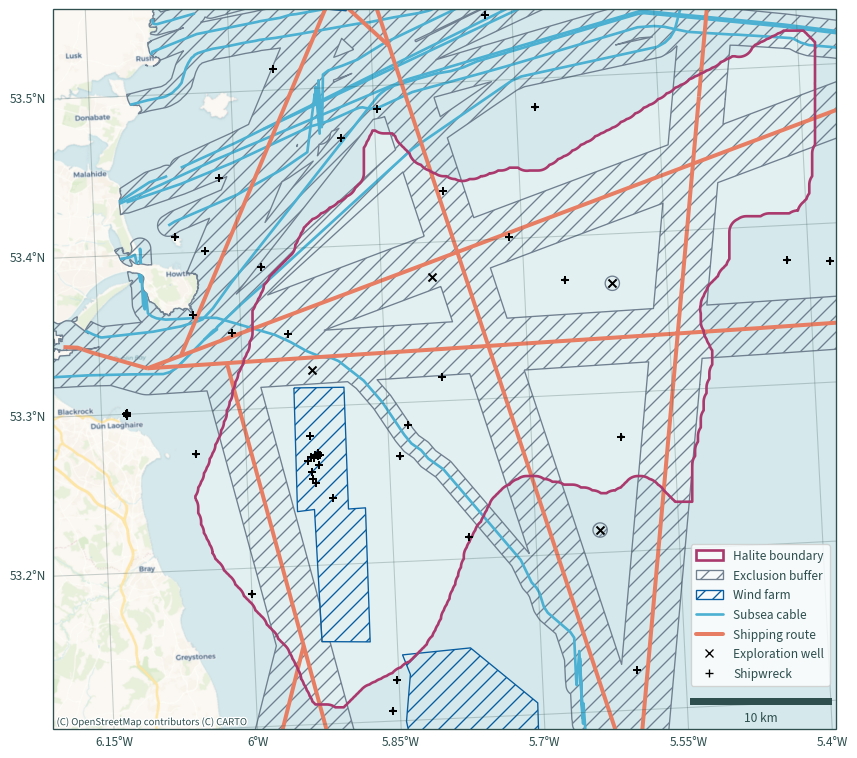

In [28]:
plot_map(ds, "Thickness", "max")

In [28]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(14, 10))
    axis = plt.axes(projection=ccrs.epsg(CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = fns.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Halite boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    for df, markersize in zip(
        [
            cavern_df[cavern_df["depth"] == "500 - 1,000"],
            cavern_df[cavern_df["depth"] == "1,000 - 1,500"],
            cavern_df[cavern_df["depth"] == "1,500 - 2,000"],
        ],
        [20, 50, 20],
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=axis,
            column="Thickness",
            zorder=3,
            markersize=markersize,
            cmap=sns.color_palette("flare", as_cmap=True),
            linewidth=0,
            marker=".",
            scheme="UserDefined",
            classification_kwds={"bins": [155 + 90, 311 + 90]},
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    palette = [
        sns.color_palette("flare", 255)[0],
        sns.color_palette("flare", 255)[127],
        sns.color_palette("flare", 255)[-1],
    ]
    for color, label in zip(palette, ["85", "155", "311"]):
        # legend_handles.append(
        #     Line2D(
        #         [0], [0], marker="o", linewidth=0, label=label, color=color
        #     )
        # )
        legend_handles.append(mpatches.Patch(facecolor=color, label=label))
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or 1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(axis, crs=CRS, source=cx.providers.CartoDB.VoyagerNoLabels)
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )

    plt.tight_layout()
    plt.show()

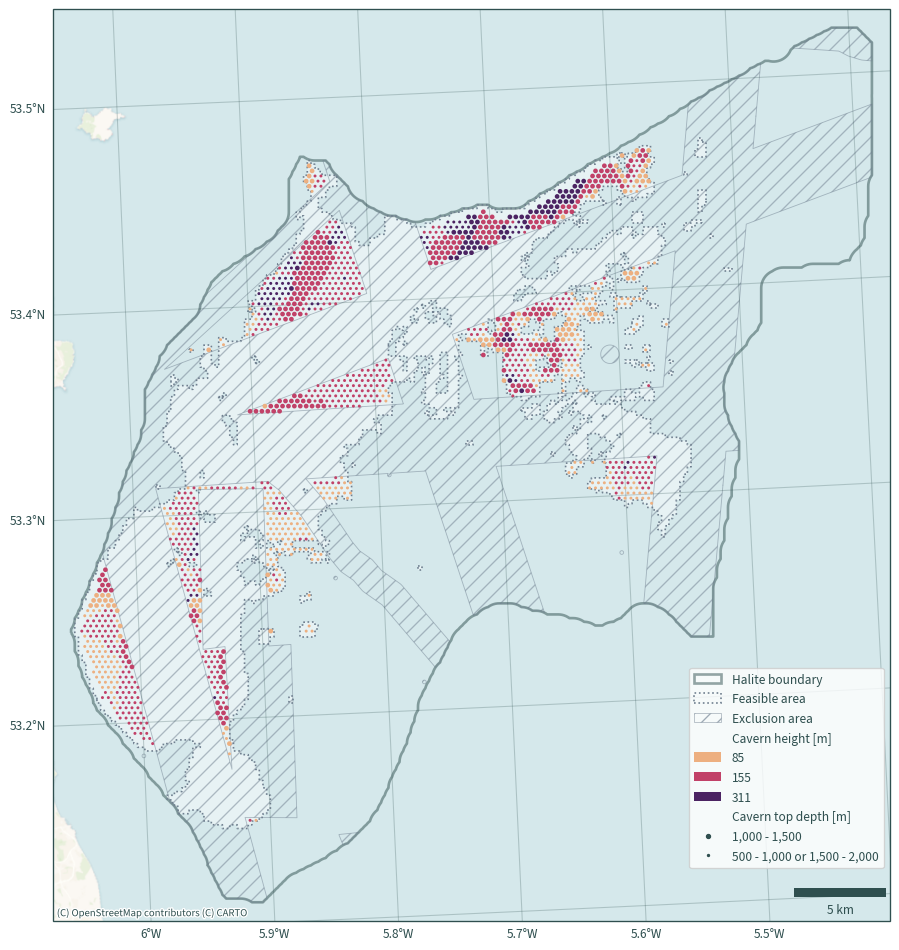

In [30]:
plot_map_alt(ds, caverns, zones)

## Stats

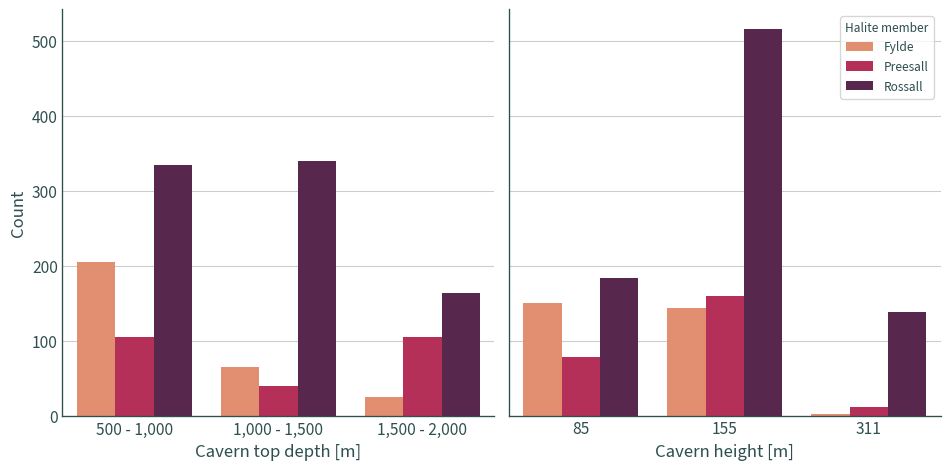

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[0],
    x="depth",
    hue="halite",
    palette="rocket_r",
    legend=False,
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
)
axes[0].set_xlabel("Cavern top depth [m]")
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[1],
    x="height",
    hue="halite",
    palette="rocket_r",
    order=["85", "155", "311"],
)
axes[1].set_xlabel("Cavern height [m]")
axes[0].set_ylabel("Count")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
plt.legend(title="Halite member")
sns.despine()
plt.tight_layout()
plt.show()

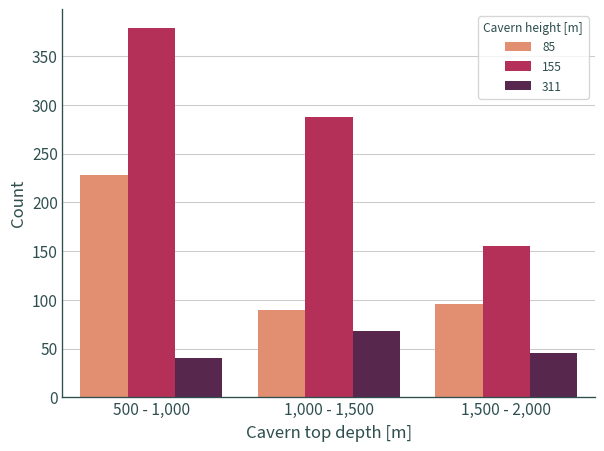

In [32]:
ax = sns.countplot(
    caverns.sort_values("Thickness"),
    x="depth",
    hue="height",
    palette="rocket_r",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
)
ax.set_xlabel("Cavern top depth [m]")
ax.set_ylabel("Count")
ax.grid(which="major", axis="y")
sns.despine()
plt.legend(title="Cavern height [m]")
plt.tight_layout()
plt.show()

In [52]:
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
height,,
85,414,29.784173
155,822,59.136691
311,154,11.079137


In [53]:
s = (
    caverns.sort_values("TopDepth")
    .groupby("depth", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
depth,,
"500 - 1,000",647,46.546763
"1,000 - 1,500",446,32.086331
"1,500 - 2,000",297,21.366906


In [54]:
s = caverns.groupby(["height", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
height depth                             
311    1,000 - 1,500        68   4.892086
       500 - 1,000          40   2.877698
       1,500 - 2,000        46   3.309353
155    1,000 - 1,500       288  20.719424
       1,500 - 2,000       155  11.151079
       500 - 1,000         379  27.266187
85     1,000 - 1,500        90   6.474820
       1,500 - 2,000        96   6.906475
       500 - 1,000         228  16.402878

## Volume

In [49]:
importlib.reload(fns)

<module 'src.functions' from '/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/src/functions.py'>

In [50]:
caverns["cavern_height"] = caverns["height"].astype(int)

In [51]:
caverns["cavern_volume"] = caverns["cavern_height"].apply(
    fns.cavern_volume, diameter=80, theta=20
)

In [52]:
caverns.head()

,geometry,halite,y,x,BaseDepth,Thickness,TopDepth,TopTWT,height,depth,cavern_height,cavern_volume
0,"POLYGON ((723360.000 5927629.322, 723359.807 5...",Rossall,5927600.0,723400.0,1771.5808,754.9858,1016.5950,637.7227,311,"1,000 - 1,500",311,702050.89015
1,"POLYGON ((723840.000 5927906.451, 723839.807 5...",Rossall,5928000.0,723800.0,1853.1515,703.3940,1149.7574,714.1552,311,"1,000 - 1,500",311,702050.89015
2,"POLYGON ((723680.000 5927629.322, 723679.807 5...",Rossall,5927600.0,723600.0,1745.3014,669.1757,1076.1257,670.5387,311,"1,000 - 1,500",311,702050.89015
3,"POLYGON ((723040.000 5927629.322, 723039.807 5...",Rossall,5927600.0,723000.0,1719.7285,658.5259,1061.2026,665.2790,311,"1,000 - 1,500",311,702050.89015
4,"POLYGON ((717920.000 5925966.554, 717919.807 5...",Rossall,5926000.0,717800.0,1493.0902,622.5118,870.5784,557.3989,311,"500 - 1,000",311,702050.89015


In [53]:
caverns["cavern_volume"].unique()

array([702050.89014954, 326452.98009604, 157915.45635409])

In [ ]:
hydrogen = Fluid(FluidsList.Hydrogen).with_state(
    Input.pressure(100e3), Input.temperature(20)
)

In [ ]:
hydrogen.density

In [ ]:
rho_approx = (
    (2.01588 / 1000)
    / (hydrogen.compressibility * 8.314 * (20 + 273.15))
    * 100e3
)